## Import libraries

In [1]:
import os
import numpy as np
from tensorflow.keras import layers, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from mtcnn.mtcnn import MTCNN
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import json

## Face detection (MTCNN)

In [2]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

####### Change as per your paths
dataset_path = '../dataset'
# model_path = 'Facenet/facenet_keras_2024.h5'
output_model_path = 'baseline_cnn_embeddings.h5' 

# Parameters
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS = 20

# Initialize MTCNN detector
detector = MTCNN()

# Get number of classes
class_names = sorted(os.listdir(dataset_path))
print(f"Classes found: {class_names}")
num_classes = len(class_names)

# Helper function to extract face from bounding box
def get_face(img, box):
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # Ensure coordinates are within image bounds
    h, w = img.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(x2, w), min(y2, h)
    if x2 <= x1 or y2 <= y1:  # Invalid box
        return None
    face = img[y1:y2, x1:x2]
    return face

# Load and preprocess data with MTCNN face detection
def load_data():
    X, y = [], []
    skipped_images = 0
    for idx, person in enumerate(class_names):
        person_path = os.path.join(dataset_path, person)
        for img_name in os.listdir(person_path):
            img_path = os.path.join(person_path, img_name)
            # Load image with OpenCV
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load {img_path}, skipping.")
                skipped_images += 1
                continue
            
            # Convert to RGB for MTCNN
            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Detect faces
            faces = detector.detect_faces(rgb_img)
            if len(faces) > 0:
                # Use the largest face (by area)
                main_face = max(faces, key=lambda x: x['box'][2] * x['box'][3])
                face_img = get_face(img, main_face['box'])
                
                if face_img is None:
                    print(f"Invalid face box in {img_path}, skipping.")
                    skipped_images += 1
                    continue
                
                # Resize and preprocess
                face_img = cv2.resize(face_img, IMG_SIZE)
                face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                face_array = face_img.astype('float32') / 255.0  # Normalize to [0,1]
                
                # Debug: Confirm detection
                print(f"Detected face in {img_path}: box={main_face['box']}")
                
                X.append(face_array)
                y.append(idx)
            else:
                print(f"No face detected in {img_path}")
                skipped_images += 1
    print(f"Total images skipped: {skipped_images}")
    return np.array(X), np.array(y)

Classes found: ['aaryan', 'ethan', 'eunice', 'jinwei', 'jonathan', 'junyong']


In [3]:
# Load dataset
X, y = load_data()

# Check if data is loaded successfully
if len(X) == 0:
    raise ValueError("No valid face data loaded. Check dataset or MTCNN detection.")

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Detected face in ../dataset\aaryan\aaryan_01.jpg: box=[200, 169, 202, 264]
Detected face in ../dataset\aaryan\aaryan_02.jpg: box=[75, 62, 60, 77]
Detected face in ../dataset\aaryan\aaryan_03.jpg: box=[562, 615, 437, 573]
Detected face in ../dataset\aaryan\aaryan_04.jpg: box=[1177, 1402, 817, 1055]
Detected face in ../dataset\aaryan\aaryan_05.jpg: box=[975, 1537, 919, 1214]
Detected face in ../dataset\aaryan\aaryan_06.jpg: box=[573, 805, 1199, 1625]
Detected face in ../dataset\aaryan\aaryan_07.jpg: box=[1043, 1685, 951, 1334]
Detected face in ../dataset\aaryan\aaryan_08.jpg: box=[1110, 1506, 897, 1175]
Detected face in ../dataset\aaryan\aaryan_09.jpg: box=[1115, 1486, 832, 1143]
Detected face in ../dataset\aaryan\aaryan_10.jpg: box=[1236, 1485, 925, 1229]
Detected face in ../dataset\aaryan\aaryan_11.jpg: box=[1375, 1446, 684, 1008]
Detected face in ../dataset\aaryan\aaryan_12.jpg: box=[628, 1186, 1045, 1357]
Detected face in ../dataset\aaryan\aaryan_13.jpg: box=[642, 1150, 1055, 1371]
D

KeyboardInterrupt: 

In [4]:
print(X_train.shape, y_train.shape)

(72, 160, 160, 3) (72,)


In [5]:
print(X_val.shape, y_val.shape)

(18, 160, 160, 3) (18,)


In [6]:
print(X_train[0].shape)

(160, 160, 3)


## Face recognition (CNN)

In [7]:
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)  # Explicit input layer
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    embeddings = layers.Dense(128, name='embeddings')(x)  # Embedding layer
    outputs = layers.Dense(num_classes, activation='softmax')(embeddings)

    model = Model(inputs=inputs, outputs=outputs)  # Functional model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Create CNN model
base_model = create_model(X_train[0].shape, len(class_names))

# Add classification head
x = base_model.output
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create a callback that saves the model's weights during training
class SaveBaseModelCallback(Callback):
    def __init__(self, base_model, filepath, monitor='val_loss', mode='min'):
        super().__init__()
        self.base_model = base_model
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = np.inf if mode == 'min' else -np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        if ((self.mode == 'min' and current < self.best) or
            (self.mode == 'max' and current > self.best)):
            print(f"\nSaving improved base model at epoch {epoch+1}")
            self.best = current
            self.base_model.save(self.filepath)

# Custom callback to compute precision, recall, and F1-score after each epoch
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(X_val), axis=1)  # Get predicted class labels
        y_true = y_val

        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        accuracy = accuracy_score(y_true, y_pred)

        print(f"\nEpoch {epoch+1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# create a checkpoint callback to save the model
base_model_saver = SaveBaseModelCallback(base_model, output_model_path)

# Create new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy')

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val), 
                    callbacks=[base_model_saver, MetricsCallback()])

# print(f"Model fine-tuned and saved as {output_model_path}")
# print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
# print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Predict on validation set
y_pred_finetune = np.argmax(model.predict(X_val), axis=1)
y_true = y_val

# Calculate metrics for the pretrained model
precision_finetune = precision_score(y_true, y_pred_finetune, average='macro')
recall_finetune = recall_score(y_true, y_pred_finetune, average='macro')
f1_finetune = f1_score(y_true, y_pred_finetune, average='macro')
accuracy_finetune = accuracy_score(y_true, y_pred_finetune)

print(f"Finetuned Model - Precision: {precision_finetune:.4f}, Recall: {recall_finetune:.4f}, F1-score: {f1_finetune:.4f}, Accuracy: {accuracy_finetune:.4f}")

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 1.7958
Epoch 1: val_loss improved from inf to 1.79012, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

Epoch 1 - Precision: 0.0972, Recall: 0.2778, F1-score: 0.1407, Accuracy: 0.2778
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step - loss: 1.7951 - val_loss: 1.7901
Epoch 2/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1.7872
Epoch 2: val_loss improved from 1.79012 to 1.78426, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Epoch 2 - Precision: 0.1111, Recall: 0.3333, F1-score: 0.1667, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - loss: 1.7870 - val_loss: 1.7843
Epoch 3/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 1.7800
Epoch 3: val_loss improved from 1.78426 to 1.77960, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 3 - Precision: 0.1385, Recall: 0.3333, F1-score: 0.1875, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - loss: 1.7796 - val_loss: 1.7796
Epoch 4/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 1.7635
Epoch 4: val_loss improved from 1.77960 to 1.77321, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Epoch 4 - Precision: 0.1125, Recall: 0.3333, F1-score: 0.1678, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - loss: 1.7658 - val_loss: 1.7732
Epoch 5/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.7693
Epoch 5: val_loss improved from 1.77321 to 1.76735, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Epoch 5 - Precision: 0.1111, Recall: 0.3333, F1-score: 0.1667, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - loss: 1.7696 - val_loss: 1.7673
Epoch 6/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 1.7666
Epoch 6: val_loss improved from 1.76735 to 1.75919, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Epoch 6 - Precision: 0.1125, Recall: 0.3333, F1-score: 0.1678, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step - loss: 1.7652 - val_loss: 1.7592
Epoch 7/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.7457
Epoch 7: val_loss did not improve from 1.75919
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Epoch 7 - Precision: 0.0889, Recall: 0.2222, F1-score: 0.1111, Accuracy: 0.2222
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 1.7451 - val_loss: 1.7617
Epoch 8/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 1.7726
Epoch 8: val_loss improved from 1.75919 to 1.75543, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Epoch 8 - Precision: 0.1190, Recall: 0.2778, F1-score: 0.1541, Accuracy: 0.2778
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - loss: 1.7699 - val_loss: 1.7554
Epoch 9/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 1.7628
Epoch 9: val_loss improved from 1.75543 to 1.74720, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Epoch 9 - Precision: 0.1111, Recall: 0.3333, F1-score: 0.1667, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - loss: 1.7612 - val_loss: 1.7472
Epoch 10/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 1.7303
Epoch 10: val_loss improved from 1.74720 to 1.74157, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Epoch 10 - Precision: 0.1125, Recall: 0.3333, F1-score: 0.1678, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - loss: 1.7305 - val_loss: 1.7416
Epoch 11/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.7360
Epoch 11: val_loss improved from 1.74157 to 1.73563, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 11 - Precision: 0.1169, Recall: 0.3333, F1-score: 0.1714, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - loss: 1.7365 - val_loss: 1.7356
Epoch 12/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 1.7231
Epoch 12: val_loss improved from 1.73563 to 1.73233, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 12 - Precision: 0.1169, Recall: 0.3333, F1-score: 0.1714, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - loss: 1.7231 - val_loss: 1.7323
Epoch 13/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.7405
Epoch 13: val_loss did not improve from 1.73233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Epoch 13 - Precision: 0.1169, Recall: 0.3333, F1-score: 0.1714, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 1.7384 - val_loss: 1.7327
Epoch 14/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 1.7221
Epoch 14: val_loss did not improve from 1.73233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 14 - Precision: 0.1250, Recall: 0.3333, F1-score: 0.1778, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 1.7202 - val_loss: 1.7375
Epoch 15/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 1.7106
Epoch 15: val_loss improved from 1.73233 to 1.73095, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Epoch 15 - Precision: 0.1250, Recall: 0.3333, F1-score: 0.1778, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - loss: 1.7099 - val_loss: 1.7309
Epoch 16/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1.7327
Epoch 16: val_loss improved from 1.73095 to 1.72314, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Epoch 16 - Precision: 0.1169, Recall: 0.3333, F1-score: 0.1714, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - loss: 1.7294 - val_loss: 1.7231
Epoch 17/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 1.7033
Epoch 17: val_loss did not improve from 1.72314
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Epoch 17 - Precision: 0.1288, Recall: 0.3333, F1-score: 0.1825, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 1.7034 - val_loss: 1.7268
Epoch 18/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.7055
Epoch 18: val_loss did not improve from 1.72314
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Epoch 18 - Precision: 0.1250, Recall: 0.3333, F1-score: 0.1778, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 1.7058 - val_loss: 1.7262
Epoch 19/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 1.6890
Epoch 19: val_loss improved from 1.72314 to 1.71170, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 19 - Precision: 0.1125, Recall: 0.3333, F1-score: 0.1678, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - loss: 1.6903 - val_loss: 1.7117
Epoch 20/20


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 1.7067
Epoch 20: val_loss improved from 1.71170 to 1.71106, saving model to baseline_cnn_embeddings.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Epoch 20 - Precision: 0.1169, Recall: 0.3333, F1-score: 0.1714, Accuracy: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step - loss: 1.7072 - val_loss: 1.7111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Finetuned Model - Precision: 0.1169, Recall: 0.3333, F1-score: 0.1714, Accuracy: 0.3333


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# Save the metrics to a JSON file

metrics = {
    "Precision": precision_finetune,
    "Recall": recall_finetune,
    "F1-score": f1_finetune,
    "Accuracy": accuracy_finetune
}

# Define the file path for saving the metrics
file_path = 'CNN_finetune_results.json'

# Save the metrics to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(metrics, json_file, indent=4)

print(f"Metrics saved to {file_path}")


Metrics saved to CNN_finetune_results.json


### Evaluate on pretrained model

In [10]:
# Load the pre-trained FaceNet model
base_model = create_model(X_train[0].shape, len(class_names))

# freeze all layers to prevent training
for layer in base_model.layers:
    layer.trainable = False

# Add classification head
x = base_model.output
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create new model
model_pretrained = Model(inputs=base_model.input, outputs=predictions)

# Compile with a lower learning rate
model_pretrained.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy')

# Train the model
history = model_pretrained.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val), 
                    callbacks=[MetricsCallback()])

# Predict on validation set
y_pred_pretrained = np.argmax(model_pretrained.predict(X_val), axis=1)
y_true = y_val

# Calculate metrics for the pretrained model
precision_pretrained = precision_score(y_true, y_pred_pretrained, average='macro')
recall_pretrained = recall_score(y_true, y_pred_pretrained, average='macro')
f1_pretrained = f1_score(y_true, y_pred_pretrained, average='macro')
accuracy_pretrained = accuracy_score(y_true, y_pred_pretrained)

print(f"Pretrained Model - Precision: {precision_pretrained:.4f}, Recall: {recall_pretrained:.4f}, F1-score: {f1_pretrained:.4f}, Accuracy: {accuracy_pretrained:.4f}")

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step- loss: 1.793

Epoch 1 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 1.7941 - val_loss: 1.7921
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7847

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Epoch 2 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 1.7856 - val_loss: 1.7921
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7991

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 3 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.7991 - val_loss: 1.7921
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7976

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Epoch 4 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.7976 - val_loss: 1.7921
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7891

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Epoch 5 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 1.7892 - val_loss: 1.7921
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7962

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Epoch 6 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 1.7965 - val_loss: 1.7921
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7892

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Epoch 7 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.7895 - val_loss: 1.7921
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7926

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 8 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.7930 - val_loss: 1.7921
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8021

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Epoch 9 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.8014 - val_loss: 1.7921
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7885

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Epoch 10 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.7885 - val_loss: 1.7921
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8042

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 11 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.8039 - val_loss: 1.7921
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7935

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Epoch 12 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.7929 - val_loss: 1.7921
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7935

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Epoch 13 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1.7939 - val_loss: 1.7921
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7845

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 14 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.7840 - val_loss: 1.7921
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7875

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Epoch 15 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.7884 - val_loss: 1.7921
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7915

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Epoch 16 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.7908 - val_loss: 1.7920
Epoch 17/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.8032

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Epoch 17 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.8027 - val_loss: 1.7920
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7883

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Epoch 18 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1.7887 - val_loss: 1.7920
Epoch 19/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7987

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 19 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.7982 - val_loss: 1.7920
Epoch 20/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7989

c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Epoch 20 - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.7984 - val_loss: 1.7920
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Pretrained Model - Precision: 0.0278, Recall: 0.1667, F1-score: 0.0476, Accuracy: 0.1667


c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jy158\miniconda3\envs\facenet\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# Save the metrics to a JSON file

metrics = {
    "Precision": precision_pretrained,
    "Recall": recall_pretrained,
    "F1-score": f1_pretrained,
    "Accuracy": accuracy_pretrained
}

# Define the file path for saving the metrics
file_path = 'CNN_pretrained_results.json'

# Save the metrics to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(metrics, json_file, indent=4)

print(f"Metrics saved to {file_path}")


Metrics saved to CNN_pretrained_results.json


### Visualization

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Specify the path to your JSON file
json_file_path = 'CNN_finetune_results.json'

# Read the JSON file
with open(json_file_path, 'r') as file:
    metrics_data = json.load(file)

print(metrics_data)

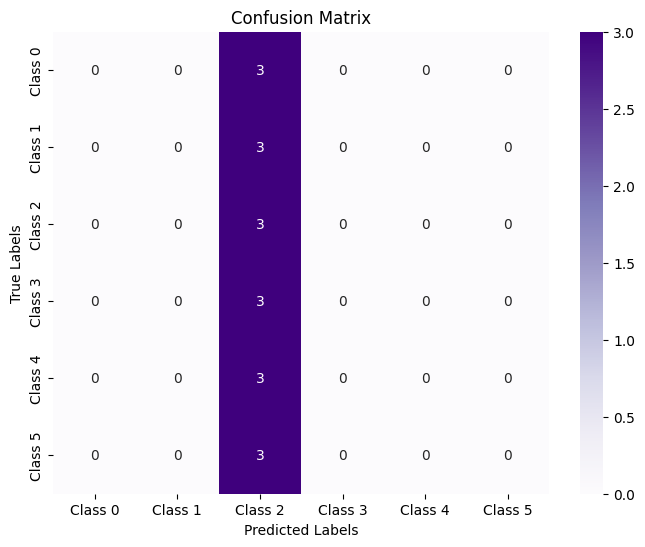

In [14]:
# Generate the confusion matrix
# cm = confusion_matrix(y_true, y_pred_finetune)
cm = confusion_matrix(y_true, y_pred_pretrained)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()